# STARDUST (cell-based version)

This Jupyter Notebook provides an interactive version of STARDUST for analysis using cell-based fluorescence data (average fluorescence per cell). The required input for this analysis one mask/map and the time series generated from the map. Functions used in this script are defined and imported from util.py. Use help() to see the documentation. 

For a more detailed description of the STARDUST pipeline, please see the biorxiv paper and github page for more information. 

## 1. Environment set up

In [ ]:
import pandas as pd, numpy as np, seaborn as sns
from src.STARDUST.util import * 

Check module versions to make sure requirements are met for STARDUST. Version information for modules are specified in the Key Resource Table in the protocol. We recommend setting up a designated conda environment for the STARDUST to avoid module version conflicts. For more information on how to set up the environment, please refer to the protocol. 

In [ ]:
check_modules()

## 2. Data input

Run the next code block to read in input files and information of the experiment. Enter the information accordingly in the prompted text boxes. 

In [ ]:
time_series_path, _, cell_mask_path, output_path = prompt_input(analysis_type = 'cell-based')
drug_frame, frame_rate, spatial_resolution = get_metadata()

Next, read in cell mask.  

In [ ]:
cell_map_array, cell_map_labeled, cell_map_count = read_tif(cell_mask_path, "cell")

## 3. Signal preprocessing

The next code block use raw_to_filtered() to extract raw traces from the input path and uses the Butterworth filter (4th order and 0.4Hz cutoff) to smooth out the signals. In our hands, filtering minimally impacts detection for true signals while lowering noise detection. 

In [ ]:
# find raw traces and create filtered traces
raw_traces, filtered_traces = raw_to_filtered(time_series_path)

Check number of cells and number of frames from the input traces. Either raw_traces and filtered_traces works for this step and should give the same results. 

In [ ]:
cell_count, frame_count = check_traces(filtered_traces)

Note that we proceed with the filtered_traces in the steps below. If wish to skip the filtering, change filtered_traces in the next code block to raw_traces.

### Optinal: Signal correction using linear regression

This optional step uses the correct_shift() function to detect and correct gradual linear drift in the traces. Ideally, the slope distribution histogram should roughly center around zero for recordings if the calcium activity stays around baseline level or returns to baseline after pharmacological application. If the distribution is not centered around zero, it might indicate photobleaching or a significant z drift during the recording.  

**DO NOT** use this correction if pharmacology application causes large increase or decrease of calcium signals. For example, 20uM norepinephrine (NE) bath application leads to a large, sustained increase of calcium signal intensity across the field of view when recording astrocyte GCaMP. Recording with such drug application should therefore not be corrected using this step. 

In [ ]:
# optional: correct traces for shift using linear regression
corrected_traces, reg = correct_shift(filtered_traces, correction_factor = 0.5)

Note that we proceed with the corrected_traces in the following steps in this protocol. If the user do not wish to use the correction, change corrected_traces in the next block to filtered_traces or raw_traces.

## 4. Baseline determination and signal detection

This step determines the baseline fluorescence level (F<sub>0</sub>) in each ROA through a three-step iteration process. Signals are then extracted after the final iteration. 

In [ ]:
# baseline determination
dff_traces, baselines, thresholds, signal_frames, signal_boundaries, signal_threshold = iterative_baseline(corrected_traces, 
                                                                                                           baseline_start = 0, 
                                                                                                           baseline_end = -1, 
                                                                                                           include_incomplete = False)

## Checkpoint 1: dF/F traces heatmap

Visualze dF/F traces using heatmap. Each row represents one cell and each column represents one frame.  

Note that for heatmap coloring, *vmin* is set at 0, and *vmax* is set at (signal_threshold + 1) * average thresholds across all cells. For example, if the signal_threshold is set at 3SD, any transients that has a dF/F value above baseline + 4SD will be colored red to facilitate visualization. You can adjust the vmax parameter if needed. 

In [ ]:
sns.heatmap(dff_traces, vmin = 0, vmax = (signal_threshold + 1) * thresholds.mean(), 
            xticklabels=100, yticklabels= False, cmap = 'jet');

## 5. Signal feature extraction

This step extracts signal features such as peak amplitude, duration, frequency, etc. Running the next code cell generates a dataframe stored in signal_stats, with each row representing one active signal. The columns detail signal features listed in table 1 in the STARDUST protocol. Some of the features are shown in the illustration below.  

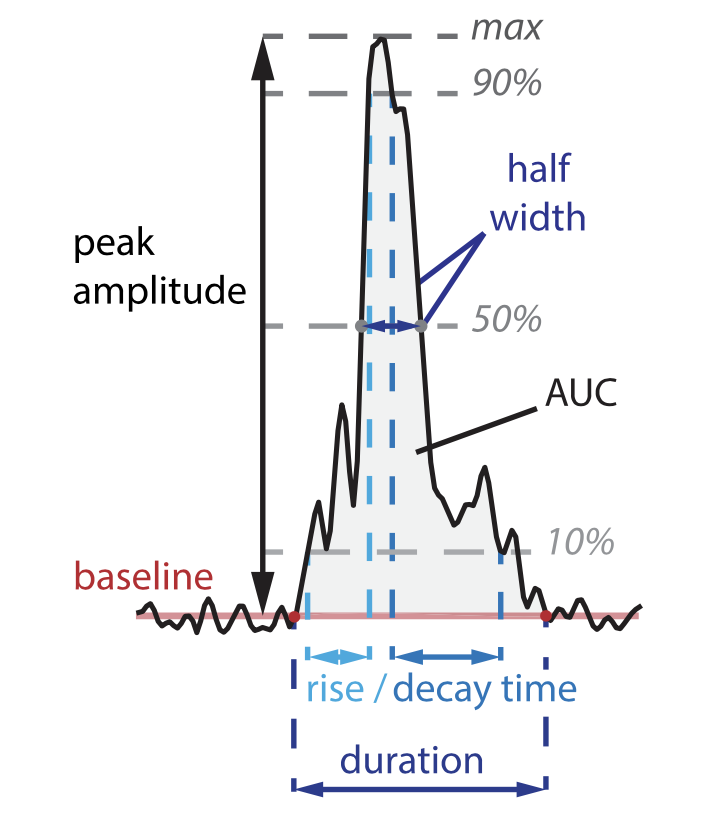

In [ ]:
signal_features = analyze_signal(dff_traces, signal_frames, signal_boundaries, frame_rate, drug_frame)

In [ ]:
signal_features.head()

## 6. Cell-based analysis

The next code block performs cell-based analysis to calculate average amplitude, AUC, signal to noise ratio, rise time, decay time, duration, inter-event interval, total signal count and frequency (per minute) for each cell during each epoch. 

In [ ]:
cell_based = cell_based(signal_features, frame_count, frame_rate, drug_frame)

In [ ]:
cell_based.head()

## Checkpoint 2: Individual traces
Use the inspect_trace() function to visualize all traces. 

In [ ]:
all_cells = range(1, cell_count + 1)
inspect_trace(all_cells, dff_traces, baselines, thresholds, drug_frame)

### Visualize a few randomly selected ROAs

In [ ]:
random_cells = np.random.choice(cell_count, 10)
random_cells.sort()
inspect_trace(random_cells, dff_traces, baselines, thresholds, drug_frame)

## 7. Data output

In [ ]:
metadata = pd.DataFrame({'frame_rate': [frame_rate], 'spatial_resolution': [spatial_resolution],
                        'drug_frame': [drug_frame], 'drug_time': [drug_frame/frame_rate], 
                        'signal_threshold': [signal_threshold]})
output_data(output_path, metadata, dff_traces, signal_features, save_as = 'csv', cell_based = cell_based)